In [1]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# Load the saved model and tokenizer
loadstr = '/home/ubuntu/bstadt-tlm/tlm/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
#tokenizer = BertTokenizerFast.from_pretrained('../coca_tokenized/tokenizer/')
tokenizer = AutoTokenizer.from_pretrained(loadstr)

In [2]:
import torch
import torch.nn.functional as F
def lyear(phrase, model, tokenizer):
    model.eval()

    years = list(range(1990, 2020))
    year_fills = ['[YEAR:{}]'.format(year) for year in years]
    year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
    year_template = '[MASK] ' + phrase
    
    input_ids = tokenizer.encode(year_template, add_special_tokens=False, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0][0]
        year_sublogits = logits[year_fill_token_ids]
        year_subprobs = F.softmax(year_sublogits, dim=0)

    return years, year_sublogits, year_subprobs

In [34]:
from matplotlib import pyplot as plt
def pyear_given_slotfill(phrase, template, model, tokenizer, title, annotate=None, annotate_text=None, vlines=None, plot_template=False, plot_fill=False):
    years, fill_year_logits, fill_year_probs = lyear(phrase, model, tokenizer)
    _, template_year_logits, template_year_probs = lyear(template, model, tokenizer)
    bayes_factors = fill_year_probs/template_year_probs

    plt.figure()
    plt.title(title)
    plt.ylabel('Bayes Factor')
    plt.xlabel('Year')
    plt.plot(years, bayes_factors)
    plt.legend()

    if annotate != None:
        plt.axvspan(annotate[0], annotate[1], alpha=0.3, color='green')
        if annotate_text != None:
            plt.text(annotate[0], 0, annotate_text, ha='left', va='bottom')

    if vlines != None:
        for vline in vlines:
            plt.axvline(vline, color='red', linestyle='--')


    plt.show()

    if plot_fill:
        plt.plot(years, fill_year_probs, label='Fill')
        plt.legend()
        plt.show()

    if plot_template:
        plt.plot(years, template_year_probs, label='Template')
        plt.legend()
        plt.show()

/tmp/ipykernel_3916774/63049280.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


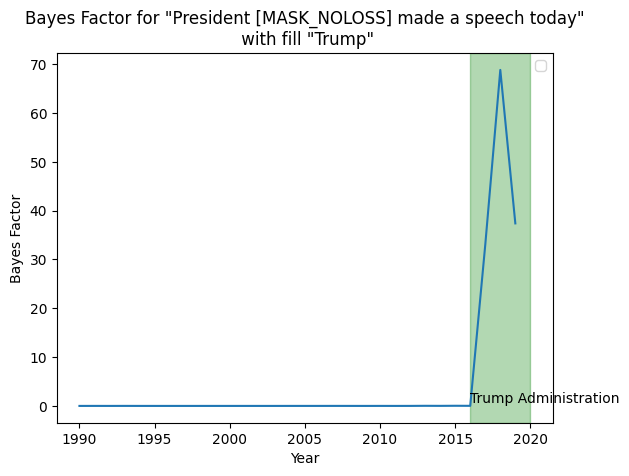

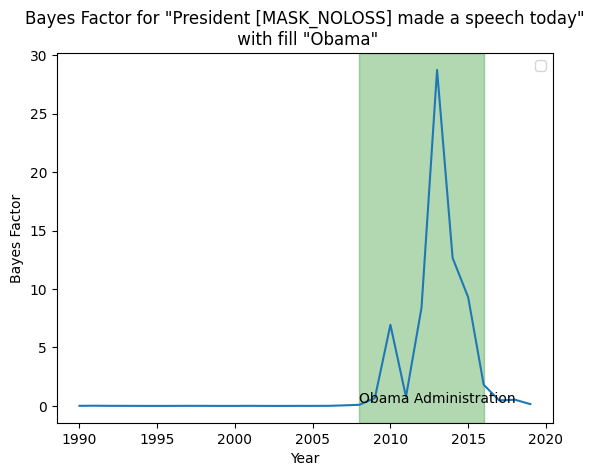

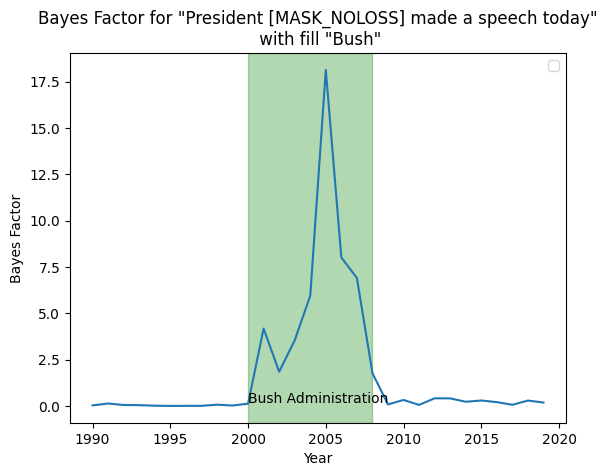

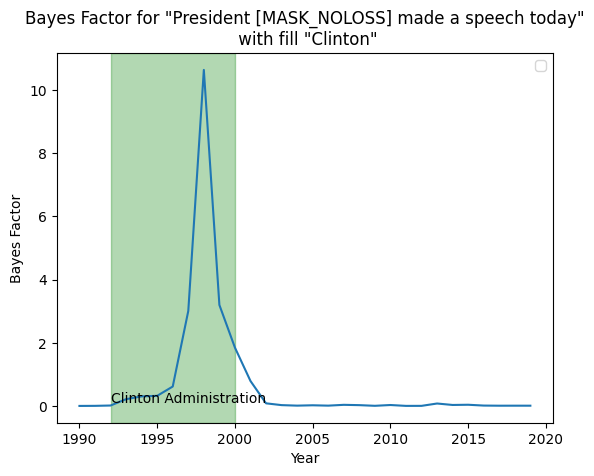

In [4]:
template = 'President [MASK_NOLOSS] made a speech today'
pyear_given_slotfill('President Trump made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Trump"',
 annotate=(2016, 2020), annotate_text='Trump Administration')
pyear_given_slotfill('President Obama made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Obama"',
 annotate=(2008, 2016), annotate_text='Obama Administration')
pyear_given_slotfill('President Bush made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Bush"',
 annotate=(2000, 2008), annotate_text='Bush Administration')
pyear_given_slotfill('President Clinton made a speech today', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "Clinton"',
 annotate=(1992, 2000), annotate_text='Clinton Administration')

/tmp/ipykernel_3916774/63049280.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


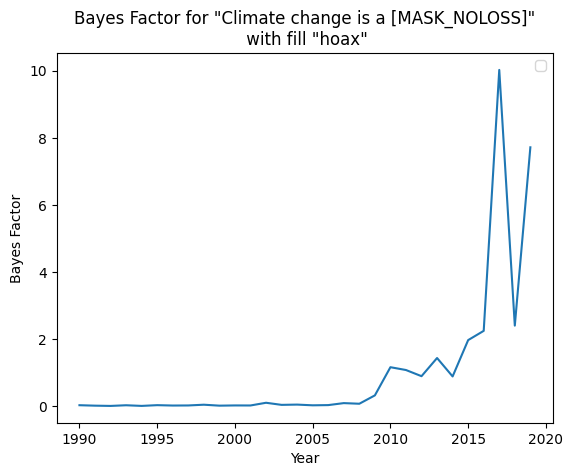

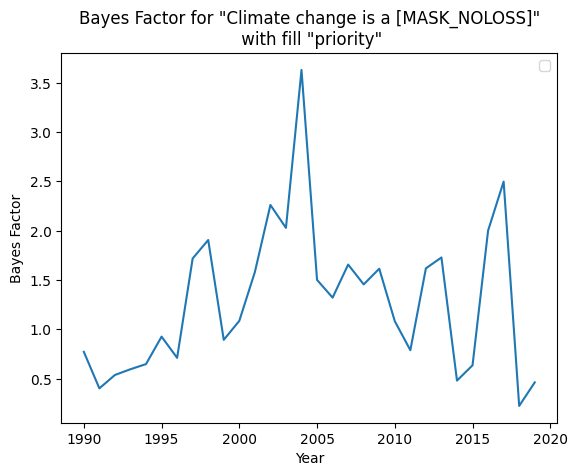

In [5]:
template = 'Climate change is a [MASK_NOLOSS]'
pyear_given_slotfill('Climate change is a hoax', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "hoax"')
pyear_given_slotfill('Climate change is a priority', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "priority"')

/tmp/ipykernel_3916774/3236602239.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


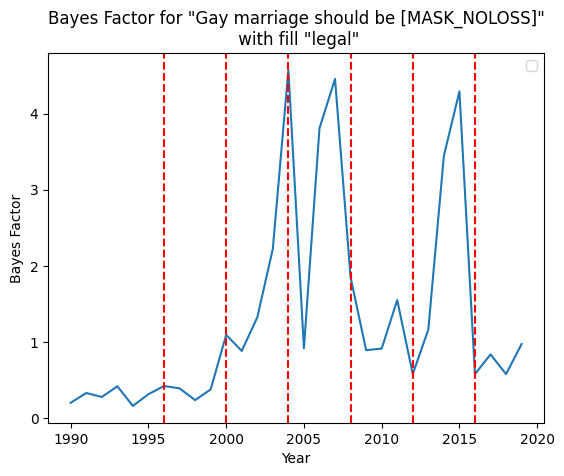

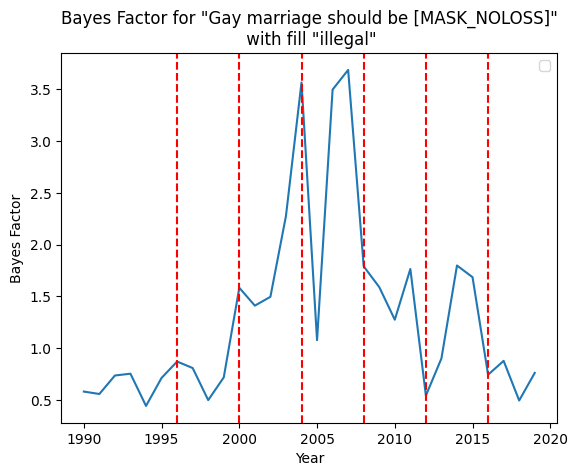

In [26]:
election_years = [1996, 2000, 2004, 2008, 2012, 2016]
template = 'Gay marriage should be [MASK_NOLOSS]'
pyear_given_slotfill('Gay marriage should be legal', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "legal"', vlines=election_years)
pyear_given_slotfill('Gay marriage should be illegal', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "illegal"', vlines=election_years)

/tmp/ipykernel_3916774/3236602239.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


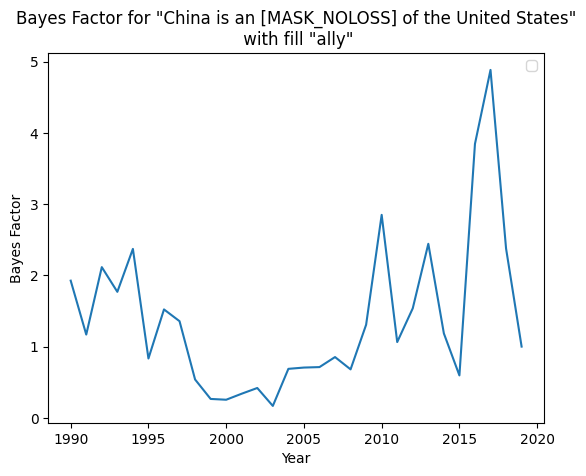

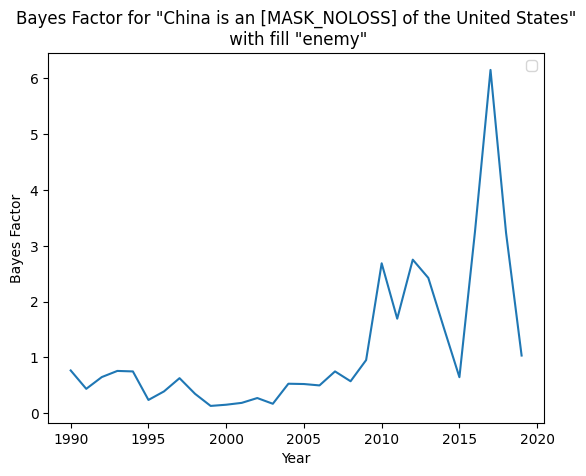

In [21]:
election_years = [1996, 2000, 2004, 2008, 2012, 2016]
template = 'China is an [MASK_NOLOSS] of the United States'
pyear_given_slotfill('China is an ally of the United States', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "ally"')
pyear_given_slotfill('China is an enemy of the United States', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "enemy"')


/tmp/ipykernel_3916774/3236602239.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


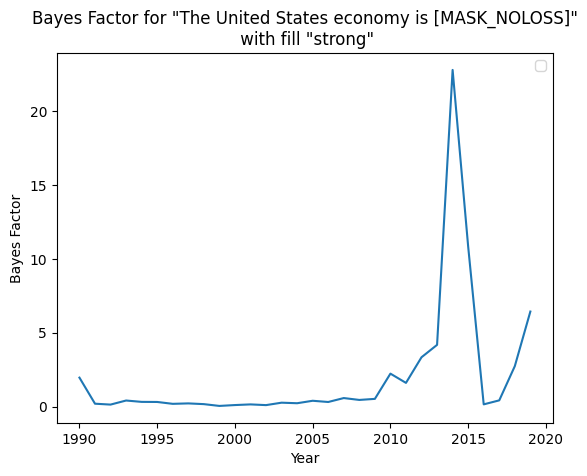

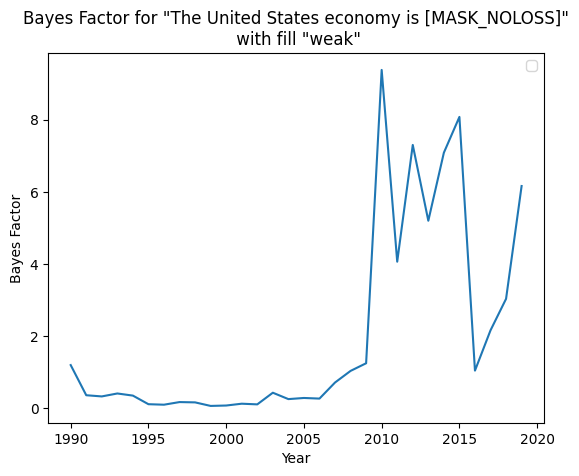

In [22]:
template = 'The United States economy is [MASK_NOLOSS]'
pyear_given_slotfill('The United States economy is strong', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "strong"')
pyear_given_slotfill('The United States economy is weak', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "weak"')


/tmp/ipykernel_3916774/3236602239.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


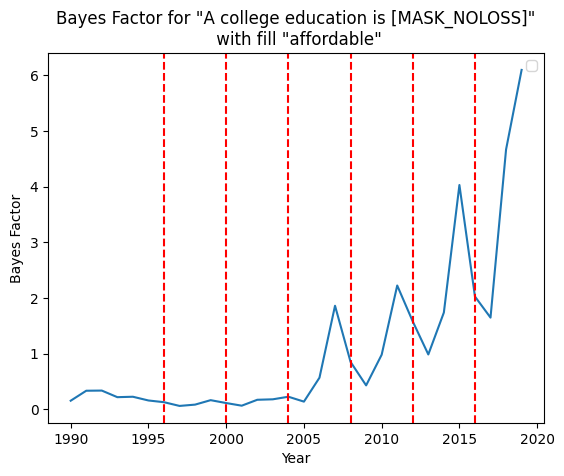

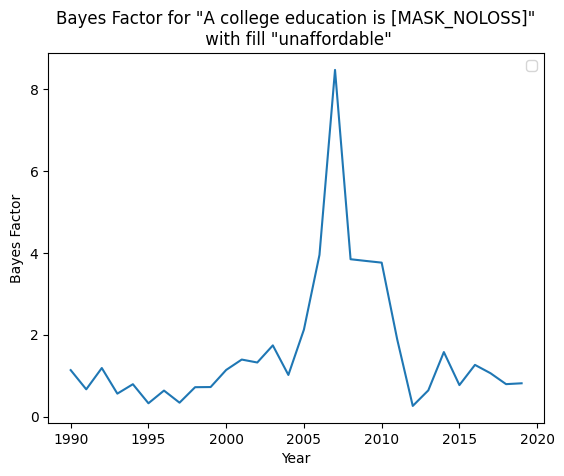

In [ ]:
template = 'A college education is [MASK_NOLOSS]'
pyear_given_slotfill('A college education is affordable', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "affordable"', vlines=election_years)
pyear_given_slotfill('A college education is unaffordable', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "unaffordable"')

/tmp/ipykernel_3916774/3221388485.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


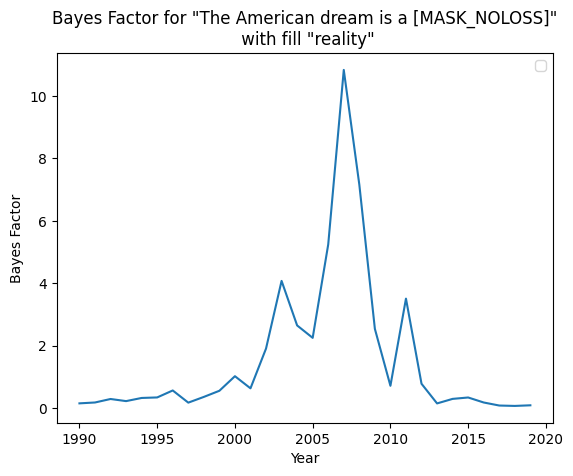

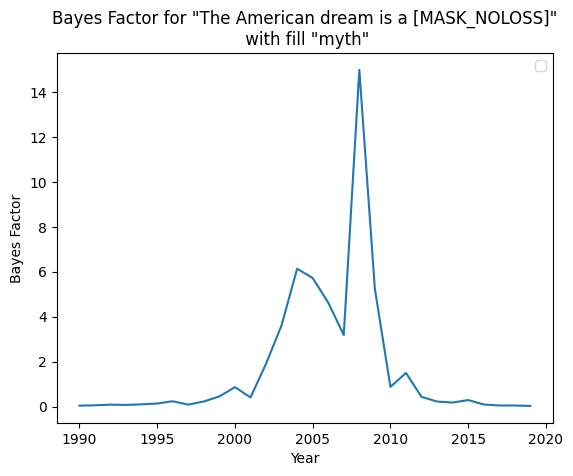

In [37]:
template = 'The American dream is a [MASK_NOLOSS]'
pyear_given_slotfill('The American dream is a reality', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "reality"')
pyear_given_slotfill('The American dream is a myth', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "myth"')

/tmp/ipykernel_3916774/3221388485.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


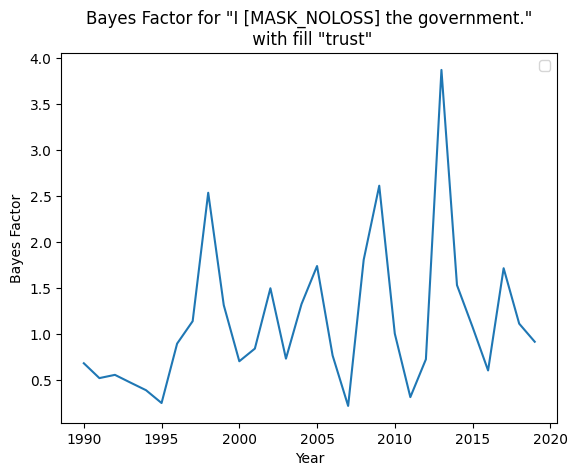

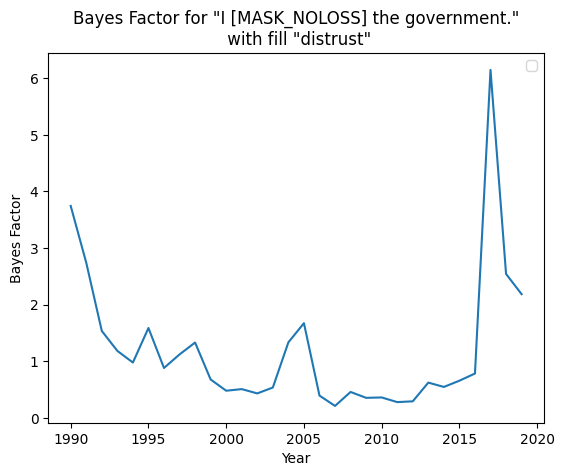

In [40]:
template = 'I [MASK_NOLOSS] the government.'
pyear_given_slotfill('I trust the government.', template, model, tokenizer,
 title='Bayes Factor for "' + template + '"\n with fill "trust"')
pyear_given_slotfill('I distrust the government.', template, model, tokenizer, 
 title='Bayes Factor for "' + template + '"\n with fill "distrust"')